<a href="https://colab.research.google.com/github/iwishyouwell/NEISS2023/blob/main/DivingIntoChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

This notebook is **best viewed in Colab**.

You may directly fork and launch your own (Colab session directly from our GitHub repos](here).

It demonstrates how to...

## Use system commands and admin tasks
- How to mount to Google Drive and create symbolic links
- How to Upload Kaggle API should you wish to connect to datasets found on Kaggle
- How to use system commands to perform simple queries
  - ```!wget```, ```unzip```
  - ```!cat```, ```grep```, ```wc -l```, ```ls```
  
- Working with large dataframe using ```Polars```

## Visualize data triplets

- Visualize sex-stratified age distributions using ```violin``` plots from ```seaborn```
- Generate interactive plots with ```plotly```
  - ```px.bar``` [(see example call)](https://colab.research.google.com/drive/1cT9j-ZfY0BWsJyBBnqYeZtJJKOA-OU2a?authuser=5#scrollTo=dUTKK_ccRzS_&line=1&uniqifier=1)
  - ```px.violin```
  - ```px.scatter``` [(see example call)](https://colab.research.google.com/drive/1cT9j-ZfY0BWsJyBBnqYeZtJJKOA-OU2a?authuser=5#scrollTo=-53rTQ165xf5&line=1&uniqifier=1)

## Simple clustering with YAKE!

- Extends notebook kindly shared by [@JimKing100](https://www.drivendata.org/competitions/217/cdc-fall-narratives/community-code/11/)
- ```Umap```: running this notebook without changes should lead to an **interactive plot** that allows you to hovering over a data point to reveal additional data as a "pop-up":

<image src="https://github.com/iwishyouwell/NEISS2023/blob/main/figures/interactive_plot_umap.png?raw=true"/>

# Technical background: info for users new to Kaggle and/or Colab

## Mount drive and Download

In [ ]:
if ('nb_path' in globals())==False:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  import os, sys
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  nb_path = '/content/notebooks'

  # symbolic to /content/drive/My Drive/Colab Notebooks
  try:
    os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
  except:
    pass

  sys.path.insert(0,nb_path)

Mounted at /content/gdrive
Mounted at /content/drive


## Demo notebook on downloading Kaggle datasets to Colab

Source: https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb


### Overview

1. Download token file ```kaggle.json```
- https://www.kaggle.com/settings/account > ```Create New Token```
- ```kaggle.json``` will download to your computer

2. Upload ```kaggle.json```
- Execute code snippet below
- Select latest copy of ```kaggle.json```
  - Will need to repeat this step whenever you updated new token

3. Mount to you Colab Drive

4. Download specific dataset, e.g.


## Install Kaggle API

In [ ]:
!ls /content/drive/MyDrive/*json

/content/drive/MyDrive/kaggle.json


In [ ]:
# first time users: remove the 0 condition to run this block
if 0 & (( 'uploaded' in globals())==False):
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

  # Creat folder ~/.kaggle/
  # Copy kaggle.json into this new folder (where Kaggle API expects to find)
  !mkdir -p ~/.kaggle/ && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
else:
  !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets list -v  # run this if you would like to see sample list of datasets available for download

### FYI: to unzip archive saved in .7z format

```
import py7zr
with py7zr.SevenZipFile('/path/to/file.7z', mode='r') as z:
    z.extractall()
```

## Import packages

In [ ]:
from pathlib import Path
import json, os
import pandas as pd

import os, sys, pickle, json
import pandas as pd
import polars as pol
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import plotly.io as pio

from tqdm import tqdm

from PIL import Image
from functools import wraps

from sklearn.manifold import TSNE

import random, math

import torch

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

try:
    os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
    IS_INTERACTIVE = 1
    folder = '../input/neiss-2023/'
    pio.renderers.default = 'notebook' # enable renderer
    ''' other options:
    ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
      'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
      'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
      'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
      'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']
    '''

except:
  try:
    if 'ipykernel' in os.environ['MPLBACKEND']:
      IS_INTERACTIVE = 2
    folder = ''
    pio.renderers.default = 'colab' # enable renderer
  except:
    IS_INTERACTIVE = 0

mode = 'publish' if IS_INTERACTIVE else 'demo'
print( 'Running in interative mode?', IS_INTERACTIVE, '(0=No | 1=Kaggle | 2=Colab)\n\nRunning mode:', mode, folder )
try:
  Path( folder + "variable_mapping.json").open("r")
except:
  if IS_INTERACTIVE==2:
    !unzip /content/drive/MyDrive/datasets/neiss-2023.zip # unzip if not found

# Introduction to the "Unsupervised wisdom" Challenge

## Recap of the meta-data

- 22 fields in the provided two csv files; variables in this notebook:

  - ```df```: primary contains 115128 samples  
  - ```df2```: supplementary contains 418393 samples
  - ```mapping```: dictionary mapping codes to string values

## Our goals

We are suggested to focus on the textual data ```narrative```, ```age```, ```gender```; to discover possible risk factors to falls in seniors

## Recap on:: the *Narratives*

NEISS' coding guidelines on the narratives:

```
- Age and sex must be at the start of the comment (i.e., 10YOM, 11MOF).
- Be descriptive and include pertinent details about the incident (i.e., who, what, why, when, where, how). Describe the sequence of events, alcohol/drug involvement, and the affected body part(s) in the middle of the comment.
- The name and spelling of the product(s) must be correct. Include information about the brand, manufacturer, and model when known.
- Include the patient’s alcohol concentration/level (BAC/BAL) whenever alcohol use is associated with the incident. If the patient’s alcohol concentration/level was not taken or recorded, the comment must state this.
- The relevant clinician’s diagnoses should be at the end of the comment exactly as written in the ED record and denoted with “DX:”. This abbreviation helps distinguish the clinician’s diagnoses from other details about symptoms and complaints. If there are multiple diagnoses, separate them with punctuation marks. If there are no clinical diagnoses in the ED record, put “NO DX” at the end of comment.
- Use sentence case (i.e., capitalize only the first word of each sentence and “DX:”) and correct any spelling errors.
```


# I. Exploratory Data Analysis (EDA)

## I-a. Load json + csv files

In [ ]:
%%capture

if ( 'df2' in globals())==False:
  with Path( folder + "variable_mapping.json").open("r") as f:
      mapping = json.load(f, parse_int=True)

  for c in mapping.keys():
      mapping[c] = {int(k): v for k, v in mapping[c].items()}

  df = pd.read_csv(folder+"primary_data.csv", parse_dates=['treatment_date'], dtype={"body_part_2": "Int64", "diagnosis_2": "Int64"} )
  df2 = pd.read_csv(folder+"supplementary_data.csv",  parse_dates=['treatment_date'], dtype={"body_part_2": "Int64", "diagnosis_2": "Int64"} )




## I-b. Create new columns

In [ ]:
%%time

if ( 'org_columns' in globals())==False:
    org_columns = df2.columns

    df2['month'] = df2.treatment_date.dt.month
    df2['year'] = df2.treatment_date.dt.year

    df2['severity'] = df2['disposition'].replace(
        {'4 - TREATED AND ADMITTED/HOSPITALIZED': 5,  # question, more or less severe?
         '2 - TREATED AND TRANSFERRED': 4,
         '1 - TREATED/EXAMINED AND RELEASED': 3,
         '5 - HELD FOR OBSERVATION': 2,
         '6 - LEFT WITHOUT BEING SEEN': 1
        })

    df2['age_cate']= pd.cut(
    df2.age,
    bins=[0,65,75,85,95,150],
    labels=["<65", "65-74", "74-85", "85-94","95+"],
    )

    # drop the 3 cases of unknown sex and then map codes to English words
    df2 = df2[df2.sex != 0]

decoded_df2 = df2.copy()

for col in mapping.keys():
    decoded_df2[col] = decoded_df2[col].map(mapping[col])

CPU times: user 1.64 s, sys: 133 ms, total: 1.77 s
Wall time: 1.84 s


## I-c. Visualize select variables with ```plotly```

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = px.histogram( decoded_df2, x='age_cate', color='sex', width=400, height=300 ); fig.show()

## I-d. Inspect a random sample of the narratives

In [ ]:
from IPython.core.display import HTML

print( df2.narrative[5::50000].to_markdown() )

|        | narrative                                                                                                                                                                                                                                                                                                                                                                                |
|-------:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|      5 | *92 YOF, PT STATES THAT SHE WAS TRYING TO REACH INTO A CABINET & SHE ACCIDENTALLY FELL. DX; FX OF THE HUMERUS,ACCIDENT FALL,BLUNT HEAD TRAUMA                                                                    

## I-e. Define a function for multi-variable visual analyses

Example: ```sex```, ```age```, and ```location```

...where ```Houses``` includ:
- Single-family homes, townhouses, duplexes, etc.
- Farmhouses
- Foster homes
- Private areas immediately surrounding houses (e.g., driveway, garage, garden, porch, patio, sidewalk, yard)
- Private living areas of apartments/condominiums

... exclude:
- Group homes
- Mobile homes
- Residential treatment facilities
- Common areas of apartments/condominiums

In [ ]:
r='ALCOHOL'
decoded_df2_pol = pol.DataFrame(decoded_df2).with_columns( pol.when(
    pol.col("narrative").str.contains(r) | pol.col("narrative").str.contains('WINE')
    ).then(1).otherwise(0).alias(r))

r='SMOKED'
decoded_df2_pol = pol.DataFrame(decoded_df2).with_columns( pol.when(
    pol.col("narrative").str.contains(r) | pol.col("narrative").str.contains('SMOKER') | pol.col("narrative").str.contains('SMOKING')
    ).then(1).otherwise(0).alias(r))


['FEMALE' 'MALE'] are possible values
font size 6


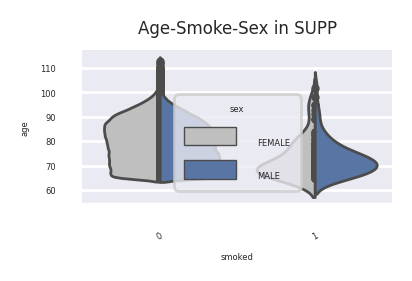

In [ ]:
def violinplot_age_sex_attribute(  decoded_df, cate_var, cont_var='age', groupby_key='sex', degs=0, add_text='', show_dots=0, figsize=(14,4), df=None, swap_axes=False ):

    sns.set_theme(style="whitegrid")

    fig=plt.figure( figsize=figsize)
    fs=figsize[0]*3

    tit=cate_var.replace('_', ' ')
    if df is not None:
      choices= df[cate_var].unique()
      l = [mapping[cate_var][c] for c in choices ]
      print('Possible values of the attribute:', l)
    else:
      l = decoded_df[cate_var].unique()

    g_keys = decoded_df[groupby_key].unique();
    print( g_keys, 'are possible values')
    for i,s in enumerate(g_keys):
      if ('f' in s.lower()):
          female_lab = s
      else:
          male_lab = s

    if show_dots:
        choice="points"
    else:
        choice="quart"


    sns.set(font_scale = fs/7 )

    if swap_axes:
      ax = sns.violinplot(data=decoded_df, y=cate_var, x=cont_var, hue="sex",
                       split=True, linewidth=1, inner=choice,
                       palette={female_lab: ".75", male_lab: "b"},  )
      ax.set_yticklabels( l, rotation=degs, );
      ax.set_xlabel( cont_var.lower(), fontsize=fs/2)
      ax.set_ylabel( cate_var.lower(), fontsize=fs/2)
    else:
      ax = sns.violinplot(data=decoded_df, x=cate_var, y=cont_var, hue="sex",
                       split=True, linewidth=1, inner=choice,
                       palette={female_lab: ".75", male_lab: "b"},  )
      ax.set_xticklabels( l, rotation=degs, );
      ax.set_ylabel( cont_var.lower(), fontsize=fs/2)
      ax.set_xlabel( cate_var.lower(), fontsize=fs/2)

    sns.despine(left=True)
    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['figure.dpi'] = 200
    print('font size',fs)
    plt.title( add_text, fontsize=fs )
    plt.tick_params(axis='both', which='major', labelsize=fs/2 )

    # for legend text
    plt.setp( ax.get_legend().get_texts(), fontsize=fs/2 )
    plt.setp( ax.get_legend().get_title(), fontsize=fs/2 )
    plt.show()

# q = decoded_df2_pol.filter( pol.col(r)==1 )

violinplot_age_sex_attribute( decoded_df2_pol.to_pandas(), cate_var='SMOKED', cont_var='age', add_text='Age-Smoke-Sex in SUPP',
                             figsize=(2,1), degs=30, show_dots=True )

['FEMALE' 'MALE'] are possible values
font size 9


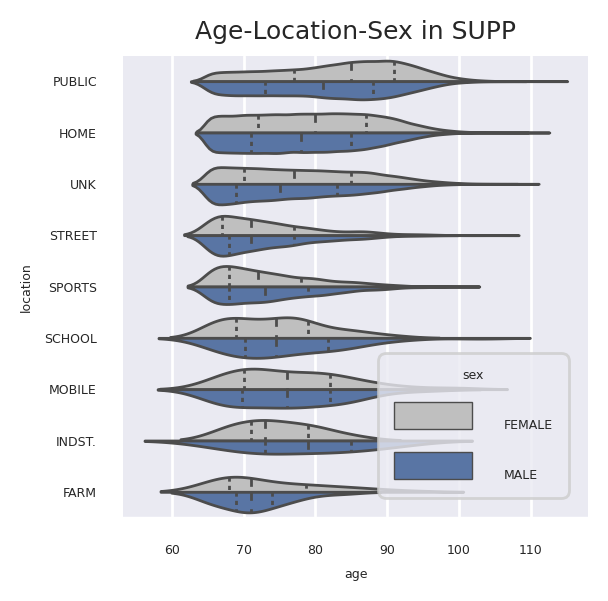

In [ ]:
violinplot_age_sex_attribute( decoded_df2_pol.to_pandas(), cate_var='location', cont_var='age', add_text='Age-Location-Sex in SUPP',
                             figsize=(3,3), swap_axes=True, degs=0, show_dots=False )

In [ ]:
decoded_df2.value_counts('race')

race
WHITE                               218544
N.S.                                160666
BLACK/AFRICAN AMERICAN               27457
OTHER                                 5785
ASIAN                                 4921
AMERICAN INDIAN/ALASKA NATIVE          746
NATIVE HAWAIIAN/PACIFIC ISLANDER       271
dtype: int64

## I-f. EDA on products involved in falls

In [ ]:
decoded_df2.value_counts('product_1')[:10]

product_1
1807 - FLOORS OR FLOORING MATERIALS                                    120111
4076 - BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED                        51011
1842 - STAIRS OR STEPS                                                  46439
4074 - CHAIRS, OTHER OR NOT SPECIFIED                                   23053
611 - BATHTUBS OR SHOWERS                                               15281
649 - TOILETS                                                           13643
676 - RUGS OR CARPETS, NOT SPECIFIED                                     9764
4057 - TABLES (EXCL.  BABY CHANGING TABLES, BILLIARD OR POOL TABLES      8352
1884 - CEILINGS AND WALLS (INTERIOR PART OF COMPLETED STRUCTURE)         7847
4078 - LADDERS, OTHER OR NOT SPECIFIED                                   6803
dtype: int64

## I-g. Severity

In [ ]:
decoded_df2.value_counts('severity')

severity
1    268981
4    130580
5      8376
2      7597
6      2288
8       560
9         8
dtype: int64

In [ ]:
d =decoded_df2.iloc[::10,:]
print(d.shape )
px.violin( d, y='age', x='severity', title='Age distributions of different severity levels', width=600 ) # sample

## I-h. Diagnosis

In [ ]:
decoded_df2.value_counts('diagnosis')

diagnosis
57 - FRACTURE            115146
62 - INTERNAL INJURY      88070
53 - CONTUSIONS, ABR.     67081
71 - OTHER                62641
59 - LACERATION           42001
64 - STRAIN, SPRAIN       17066
58 - HEMATOMA             10120
72 - AVULSION              5033
55 - DISLOCATION           3979
52 - CONCUSSION            3638
68 - POISONING             1374
61 - NERVE DAMAGE           624
66 - HEMORRHAGE             395
51 - BURNS, THERMAL         267
60 - DENTAL INJURY          241
63 - PUNCTURE               187
48 - BURN, SCALD            141
56 - FOREIGN BODY           101
54 - CRUSHING                57
50 - AMPUTATION              56
65 - ANOXIA                  48
74 - DERMA/CONJUNCT          31
42 - ASPIRATION              30
69 - SUBMERSION              16
49 - BURN, CHEMICAL          12
47 - BURN, NOT SPEC.         12
67 - ELECTRIC SHOCK          11
41 - INGESTION               10
46 - BURN, ELECTRICAL         1
73 - RADIATION                1
dtype: int64

## I-i. New diagnoses of dementia, etc.?

In [ ]:
try:
  for k2 in ['diagnosis', 'other_diagnosis', 'diagnosis_2']:
    print('New index dx cases of dementia, etc.?')
    for k in ['CONTUSIONS','DEMENTIA', 'PARKINSON', 'ALZHEIMER']:
      p=' '.join(decoded_df2[[k2]]).find(k)
      print(f'\tCounts of {k}:', p)
except:
  pass

New index dx cases of dementia, etc.?
	Counts of CONTUSIONS: -1
	Counts of DEMENTIA: -1
	Counts of PARKINSON: -1
	Counts of ALZHEIMER: -1
New index dx cases of dementia, etc.?
	Counts of CONTUSIONS: -1
	Counts of DEMENTIA: -1
	Counts of PARKINSON: -1
	Counts of ALZHEIMER: -1
New index dx cases of dementia, etc.?
	Counts of CONTUSIONS: -1
	Counts of DEMENTIA: -1
	Counts of PARKINSON: -1
	Counts of ALZHEIMER: -1


In [ ]:
!cat supplementary_data.csv | grep "EARLY ONSET" | wc -l
!cat supplementary_data.csv | grep "EARLY ONSET"

cat: supplementary_data.csv: No such file or directory
0
cat: supplementary_data.csv: No such file or directory


# II. Extract keywords in narratives using ```YAKE```

```
YAKE! is a light-weight unsupervised automatic keyword extraction method which rests on text statistical features extracted from single documents to select the most important keywords of a text. Our system does not need to be trained on a particular set of documents, neither it depends on dictionaries, external-corpus, size of the text, language or domain. To demonstrate the merits and the significance of our proposal, we compare it against ten state-of-the-art unsupervised approaches (TF.IDF, KP-Miner, RAKE, TextRank, SingleRank, ExpandRank, TopicRank, TopicalPageRank, PositionRank and MultipartiteRank), and one supervised method (KEA).
```

Source: Campos, R., Mangaravite, V., Pasquali, A., Jatowt, A., Jorge, A., Nunes, C. and Jatowt, A. (2020). YAKE! Keyword Extraction from Single Documents using Multiple Local Features. In Information Sciences Journal. Elsevier, Vol 509, pp 257-289


### Background info: YAKE!'s algorithm

Input: text, n-gram ($n$), dup threshold (θ), window size ($w$)
```
1:  # (Step 1) Text pre-processing and candidate term identification
2:  sentences = split text into sentences
3:  for each sentence in sentences do
4:    Pre-process (sentence, language)
5:  end for
6:  # (Step 2) Feature extraction & (Step 3) Term score
7:  for each term in sentences do
8:    Feature extraction
9:    Compute term weight
10:  end for
11:  # (Step 4) n-gram generation
12:  for each sentence in sentences do
13:    chunks = split sentence into chunks
14:    for each chunk in chunks do
15:      Build n-gram candidateKeywords list
16:    end for
17:  end for
18:  # (Step 4) Candidate keyword score
19:  for each candidate in candidateKeywords do
20:    Compute candidateKeywords weight
21:  end for
22:  # (Step 5) Data deduplication
23:  for each candidate1, candidate2 in candidateKeywords do
24:    if DistanceSimilarity(candidate1, candidate2) > θ:
25:      Remove candidate from candidateKeywords
26:  end for
27:  # (Step 5) Ranking
28:  Keywords = sort (candidateKeywords) by ascending score
Output: (Keywords, score)
```

Source: [DOI of paper](https://www.sciencedirect.com/science/article/pii/S0020025519308588)

## II-a. Divide narratives into "Main" and diagnosis ("Dx")

In [ ]:
def strip_basic_info( l ):
    for a in ['YOF', 'YO FEMALE', 'Y/O FEMALE', 'YO F', 'YF', 'Y O F', 'YOM', ' YWF',
              'YO MALE', 'YO M', 'Y O M', 'YM', 'Y/O WM',
              'Y/O MALE' , 'Y/O M', 'OLD FE', 'OLD MALE ', 'FEMALE', 'MALE']:
        try:
            l = l.split(a[:10])[1]
            l = l[:2].replace(' ','').replace(', ', '').replace(',', '').replace('-', '').replace('#', '').replace('.', '') + l[2:]
            break
        except:
            pass
    ll=l.split('DX')
    try:
        dx = ll[1]
    except:
        dx = ''
    return ll[0], dx

In [ ]:
%%time

try:
  !mkdir /content/drive/MyDrive/datasets/NEISS-2023/
except:
  pass

if 1:
  outdir = '/content/drive/MyDrive/datasets/NEISS-2023/'
  # do not rerun try-block if folder of processed files already made

  dat = decoded_df2[['narrative']].values

  with open( outdir+"narratives.txt", "w") as f:
    with open( outdir+"narratives_dx.txt", "w") as f2:
      for l in dat:

        # illustrative example to strip
        ll,dx= strip_basic_info( l[0] )
        dx=dx.replace(':','')
        if len(ll)>0:
          f.write( ''.join( ll ) + '\n')
        if len(dx)>0:
          f2.write( ''.join( dx ) + '\n')

  with open( outdir+"narratives.txt", "r") as f:
      dat = f.read().splitlines()

  with open( outdir+"narratives_dx.txt", "r") as f:
      dat_dx = f.read().splitlines()


mkdir: cannot create directory ‘/content/drive/MyDrive/datasets/NEISS-2023/’: File exists
CPU times: user 3.06 s, sys: 103 ms, total: 3.16 s
Wall time: 3.77 s


In [ ]:
%%time
# took 4 minutes to run

if 0:

  # load if already computed

  z=np.load( outdir + '/narrative_keywords.npz' )
  keywords = z['keywords']

else:

  # first time user run this block; switch otherwise so you can save the calculations and reload from file in future sessions
  !pip install yake

  import yake

  all_text = '|'.join(dat)

  max_ngram_size = 1
  deduplication_threshold = 0.9
  deduplication_algo = 'seqm'
  windowSize = 1
  numOfKeywords = 1000
  custom_kw_extractor = yake.KeywordExtractor(lan='en',
                                              n=max_ngram_size,
                                              dedupLim=deduplication_threshold,
                                              dedupFunc=deduplication_algo,
                                              windowsSize=windowSize,
                                              top=numOfKeywords,
                                              features=None)

  keywords = custom_kw_extractor.extract_keywords(all_text)

  # save to file so we don't have to rerun
  np.savez_compressed( outdir + '/narrative_keywords', keywords=keywords )


## II-b. Visualize the most/lesser significant keywords via a bar chart

In [ ]:
df = pd.DataFrame( keywords, columns= ['keyword', 'significance' ] )
df.significance = np.log10( 1/(1e-10+d.iloc[:,1] ) )

print(df.iloc[:50,].shape )
print(df.head(5))

# Note TDY=today, YTD=yesterday

r = np.array( list(range(999,990,-1)) + list(range(500,489,-1)) + list(range(10,-1,-1)) )
fig=px.bar( df.iloc[r,], x='significance', y='keyword', orientation='h', width=400, height=800, title='Survey of lesser/most sign. keywords')

## II-c. Trim the keywords to exclude falls, etc.

In [ ]:
# falls, falling, fall repeated and can be skipped

yake_kws = ' '.join( df.keyword ).replace( 'FALLS','').replace('FALLING','').replace('FALL','').replace('FELL','').replace('  ','').split(' ')
yake_kws.remove('')
yake_kws= list(set(yake_kws))
len(yake_kws), 'Sample list of keywords', yake_kws[::200]

(992,
 'Sample list of keywords',
 ['CABINETS', 'EVAL', 'EXERCISE', 'DUE', 'FEEL'])

## II-d. Encode occurence of keyword as features

- Included sex unsupervised clustering

In [ ]:
%%time
# took 1 min
if ('yake_features' in globals() )==False:
  yake_features = pol.DataFrame( df2[['narrative','sex']] )
  display(yake_features.head(3))

  for i,r in enumerate( tqdm( yake_kws ) ):
    yake_features= yake_features.with_columns( pol.when(pol.col("narrative").str.contains(r) ).then(1).otherwise(0).alias(r))

X = yake_features.select( pol.all().exclude( 'narrative' ) )
X = X.to_pandas().set_index( decoded_df2.index )

# will not save X because it did not take long to (re)calculate

narrative,sex
str,i64
"""86YOF AT NURSI…",2
"""83YOF AT ASSIS…",2
"""89YOF TAKING D…",2


100%|██████████| 992/992 [00:22<00:00, 43.85it/s]


CPU times: user 19.5 s, sys: 4.7 s, total: 24.2 s
Wall time: 26.2 s


In [ ]:
R=100 # draw a subset of the training cases and increase size if your resources (RAM) permit

X_trn = X.iloc[::R,:]

X_trn.sex=X_trn.sex-1

race = decoded_df2.race[::R].values

print(X_trn.shape, np.max(X_trn.to_numpy()), )

In [ ]:
X_trn.race.unique()

array([1, 0, 4, 3, 2, 5, 6])

## II-e. Preliminary clustering of keywords extracted by YAKE!, along with sex, age, race info

In [ ]:
%%capture

!pip install umap-learn

In [ ]:
%%time
import umap

embedding = umap.UMAP().fit_transform( X_trn )

df = pd.DataFrame( dict(x=embedding[:,0], y=embedding[:,1], race=race ) )


CPU times: user 9.6 s, sys: 139 ms, total: 9.74 s
Wall time: 9.46 s


In [ ]:
fig=px.scatter( df, x='x', y='y', color='race', hover_data='race', width=600, height=400, title='Color clusters by race (for demo purpose only)')
fig.show()

In [ ]:
outdir

'/content/drive/MyDrive/datasets/NEISS-2023/'

# III. Consider sharing your notebook too? Don't forget to generate and upload ```requirements.txt```

Note that all users are limited to 5MB of upload space.

(Hence, we were not be able to include too many plots for demo so please poke around our demo)

In [ ]:
!pip freeze > /content/drive/MyDrive/datasets/NEISS-2023/requirements.txt

# To be continued

## Please upvote if you find this notebook helpful. Thanks for your support!
